#library

In [1]:
import os
import glob
import random
import math
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
#from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations
from skimage.feature import local_binary_pattern
import cv2

In [17]:
def largest_contour(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 15)
  kernelSize = (5, 5)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
  contours, hierarchy= cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  all_areas= []
  for cnt in contours:
      area= cv2.contourArea(cnt)
      all_areas.append(area)
  sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

  return sorted_contours[0]

#Part1.compatness

In [3]:
def compatness(image):
  contour = largest_contour(image)
  area = cv2.contourArea(contour)
  perimeter = cv2.arcLength(contour, True)
  compactness_score = (4 * np.pi * area) / (perimeter * perimeter)
  return compactness_score

#Part2.eccenticity

In [4]:
def eccenticity(image):
  contour = largest_contour(image)
  (x, y), (minor_axis, major_axis), angle = cv2.fitEllipse(contour)
  eccentricity_score = math.sqrt(1 - (minor_axis / major_axis) * (minor_axis / major_axis))
  return eccentricity_score

#Part3.solidity

In [5]:
def solidity(image):
  contour = largest_contour(image)
  area = cv2.contourArea(contour)
  hull = cv2.convexHull(contour)
  hull_area = cv2.contourArea(hull)
  solidity_score = float(area)/hull_area
  return  solidity_score

#Part4.LBP

In [6]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	lbp = local_binary_pattern(gray, numPoints, radius, method='uniform')
	n_bins = int(lbp.max() + 1)
	hist_values, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
	return hist_values

In [ ]:
import glob
plane_path = '/content/dataset/ship/'
im_list = glob.glob(plane_path + '*.jpg')
for im_path in im_list:
  image = cv2.imread(im_path)
  print(list(histogram_of_LBP(image, 8, 2)))
  break

[0.05301789505611162, 0.06527145890203215, 0.013770094024871095, 0.03842887473460722, 0.03524416135881104, 0.13281771307249013, 0.03897482559902942, 0.08777676675765848, 0.3605702153472854, 0.17412799514710342]


#validate function

In [ ]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

In [ ]:
validating_func('/content/dataset/ship/1073645.jpg', '/content/dataset/airplane/airplane1.jpg')

Result for ship image:
compatness is : 0.093616023208505		eccenticity is : 0.9986409156043073		solidity is : 0.7504347826086957
Result for airplane image:
compatness is : 0.010229059865279236		eccenticity is : 0.8987501440101718		solidity is : 0.16793144949156452


#Part5.prepare dataset(just run this cell and not change)

In [ ]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

In [8]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [22]:
 x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [10]:
def get_featureMatrix(data):
  train_count = len(data)
  feature_matrix = [None] * train_count
  for i in range(train_count):
    compactness_score = compatness(data[i])
    eccenticity_score = eccenticity(data[i])
    solidity_score = solidity(data[i])
    lbp = histogram_of_LBP(data[i], 16, 2)
    feature_vec = np.concatenate((np.array([compactness_score, eccenticity_score, solidity_score]), lbp), axis=None)
    feature_matrix[i] = feature_vec

  return feature_matrix

In [23]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train 
clf = svm.SVC()
clf.fit(feature_matrix_train, y_train)

SVC()

#Part7

In [24]:
#test on test dataset
feature_matrix_test = get_featureMatrix(x_test)
y_pred = clf.predict(feature_matrix_test)
accuracy_score(y_test, y_pred)

0.78125

#Part8

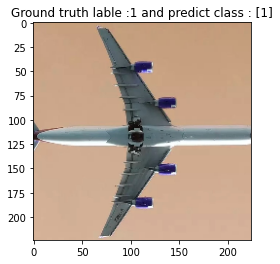

In [21]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()